In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from skimage.feature import hog, local_binary_pattern


In [ ]:
 
from skimage.feature import local_binary_pattern, hog


In [ ]:
import os
import numpy as np
from skimage.feature import local_binary_pattern, hog
import cv2

def extract_features(image_path):
    # Extraction of the main features from each image
    # Color histogram, LBP, and HOG features
    img = cv2.imread(image_path)
    img = cv2.resize(img, (150, 150))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    color_features = cv2.calcHist([img], [0,1,2], None, [8,8,8],
                                  [0,256,0,256,0,256]).flatten()
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, 10), range=(0, 9))
    hog_features = hog(gray,
                       orientations=8,
                       pixels_per_cell=(16,16),
                       cells_per_block=(1,1),
                       visualize=False)
    return np.hstack([color_features, lbp_hist, hog_features])

root_dir = "/home/oween/Escritorio/Is_it_a_Sperm/data_split"

all_features = []
all_labels   = []

for split in ("train","val","test"):
    split_dir = os.path.join(root_dir, split)
    # Collect all bmp files (case-insensitive), recursive  
    bmp_paths = []
    for dirpath, _, files in os.walk(split_dir):
        for f in files:
            if f.lower().endswith(".bmp"):
                bmp_paths.append(os.path.join(dirpath, f))
    print(f"Found {len(bmp_paths)} .bmp files in '{split}'")  # DEBUG

    for img_path in bmp_paths:
        feats = extract_features(img_path)
        all_features.append(feats)
        all_labels.append(split)

# Only stack if we actually found something
if len(all_features) == 0:
    raise RuntimeError("No .bmp files found—please check your `root_dir` path and file extensions.")
    
X = np.vstack(all_features)
y = np.array(all_labels)
print(f"Processed {X.shape[0]} images; feature vector size = {X.shape[1]}")


Found 2100 .bmp files in 'train'
Found 450 .bmp files in 'val'
Found 450 .bmp files in 'test'
Processed 3000 images; feature vector size = 1169


In [9]:
def load_dataset(data_dir):
    features = []
    labels = []
    class_names = ['normal', 'abnormal', 'non_sperm']
    
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            features.append(extract_features(img_path))
            labels.append(class_idx)
    
    return np.array(features), np.array(labels), class_names

In [ ]:

# --- Configuration of folders  ---
ROOT_DIR    = "/home/oween/Escritorio/Is_it_a_Sperm/data_split"
OUTPUT_DIR  = "/home/oween/Escritorio/Is_it_a_Sperm/results"

TRAIN_DIR = os.path.join(ROOT_DIR, "train")
VAL_DIR   = os.path.join(ROOT_DIR, "val")
TEST_DIR  = os.path.join(ROOT_DIR, "test")

In [12]:
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [13]:
# --- Feature Extraction ---
def extract_features(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (150, 150))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Color histogram
    color_features = cv2.calcHist(
        [img], [0,1,2], None, [8,8,8], [0,256,0,256,0,256]
    ).flatten()

    # Texture (LBP)
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, 10), range=(0, 9))

    # Shape (HOG)
    hog_features = hog(
        gray,
        orientations=8,
        pixels_per_cell=(16,16),
        cells_per_block=(1,1),
        visualize=False
    )

    return np.hstack([color_features, lbp_hist, hog_features])

In [14]:
# --- Data Loader ---
def load_dataset(split_dir):
    X, y, filenames = [], [], []
    class_names = sorted([
        d for d in os.listdir(split_dir)
        if os.path.isdir(os.path.join(split_dir, d))
    ])
    class_to_idx = {cls: i for i, cls in enumerate(class_names)}

    for cls in class_names:
        cls_path = os.path.join(split_dir, cls)
        for fname in os.listdir(cls_path):
            if not fname.lower().endswith(('.bmp', '.png', '.jpg', '.jpeg')):
                continue
            full_path = os.path.join(cls_path, fname)
            feats = extract_features(full_path)
            X.append(feats)
            y.append(class_to_idx[cls])
            filenames.append(fname)

    X = np.vstack(X)
    y = np.array(y)
    return X, y, filenames, class_names


In [15]:
# --- Load Data ---
X_train, y_train, train_files, class_names = load_dataset(TRAIN_DIR)
X_val,   y_val,   val_files,   _           = load_dataset(VAL_DIR)
X_test,  y_test,  test_files,  _           = load_dataset(TEST_DIR)


In [16]:
# --- Model Training ---
# 1) SVM Pipeline
svm_model = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=10, gamma='scale', probability=True)
)
svm_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=10, probability=True))])

In [17]:

# 2) Random Forest Pipeline
rf_model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
)
rf_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=10, random_state=42))])

In [18]:
def evaluate_model(model, X, y, class_names, split_name):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)

    print(f"--- {split_name} Classification Report ---")
    print(classification_report(y, y_pred, target_names=class_names))

    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{split_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return y_pred, y_prob

--- SVM Test Classification Report ---
                precision    recall  f1-score   support

Abnormal_Sperm       0.73      0.75      0.74       151
     Non-Sperm       0.83      0.83      0.83       146
  Normal_Sperm       0.81      0.78      0.80       153

      accuracy                           0.79       450
     macro avg       0.79      0.79      0.79       450
  weighted avg       0.79      0.79      0.79       450



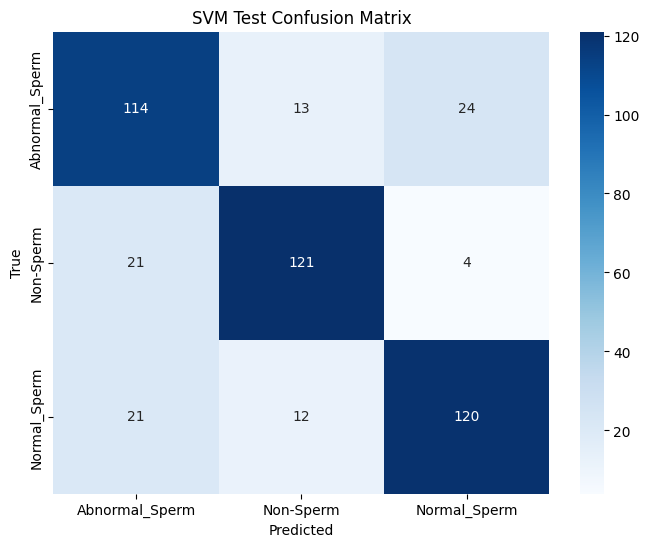

--- RF Test Classification Report ---
                precision    recall  f1-score   support

Abnormal_Sperm       0.76      0.77      0.76       151
     Non-Sperm       0.85      0.80      0.82       146
  Normal_Sperm       0.80      0.83      0.81       153

      accuracy                           0.80       450
     macro avg       0.80      0.80      0.80       450
  weighted avg       0.80      0.80      0.80       450



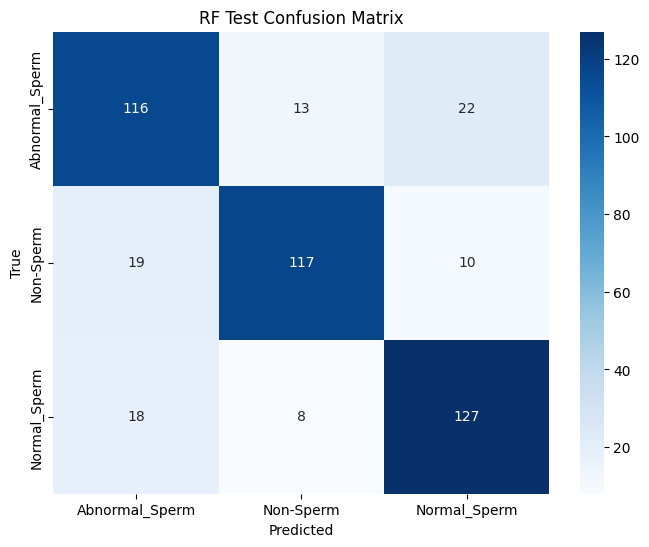

In [19]:
# Evaluate on Test Set
svm_pred, svm_prob = evaluate_model(svm_model, X_test, y_test, class_names, 'SVM Test')
rf_pred,  rf_prob  = evaluate_model(rf_model,  X_test, y_test, class_names, 'RF Test')


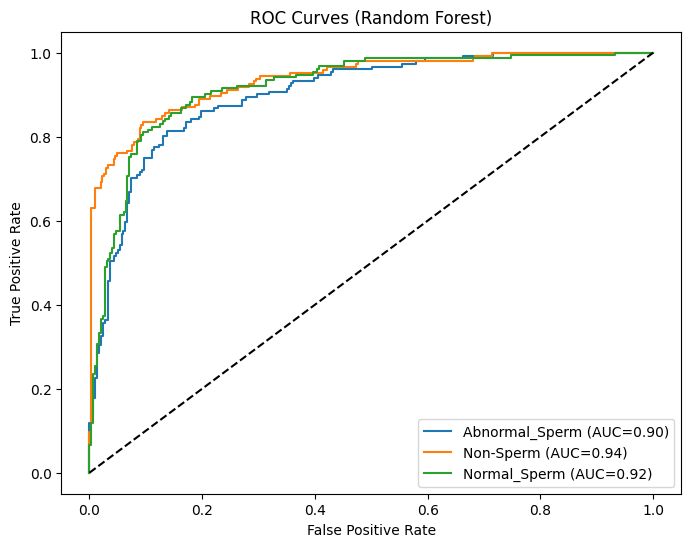

In [21]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_bin    = label_binarize(y_test, classes=range(len(class_names)))
y_prob   = rf_prob  # from evaluate_model
plt.figure(figsize=(8,6))
for i, cls in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_bin[:,i], y_prob[:,i])
    plt.plot(fpr, tpr, label=f"{cls} (AUC={auc(fpr,tpr):.2f})")
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curves (Random Forest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


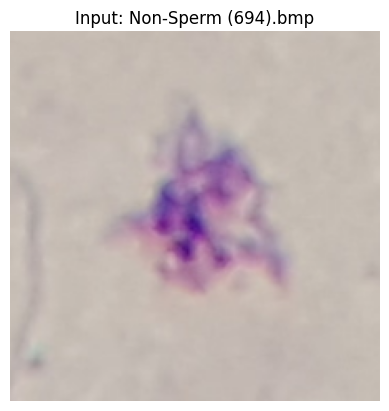

Predicted class: Non-Sperm
  Abnormal_Sperm: 0.094
  Non-Sperm: 0.860
  Normal_Sperm: 0.046


(1, array([0.09390845, 0.86017225, 0.0459193 ]))

In [25]:
import matplotlib.pyplot as plt
import cv2

def predict_image(image_path, model, class_names):
    # 1) Load & display
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Input: {os.path.basename(image_path)}")
    plt.show()

    # 2) Extract features
    feats = extract_features(image_path).reshape(1, -1)

    # 3) Predict
    pred = model.predict(feats)[0]
    prob = model.predict_proba(feats)[0]

    print(f"Predicted class: {class_names[pred]}")
    for cls, p in zip(class_names, prob):
        print(f"  {cls}: {p:.3f}")
    return pred, prob

# Example usage:"
image_to_test = "/home/oween/Escritorio/Is_it_a_Sperm/data_split/val/Non-Sperm/Non-Sperm (694).bmp"
predict_image(image_to_test, rf_model, class_names)



=== Testing: Non-Sperm (455).bmp ===



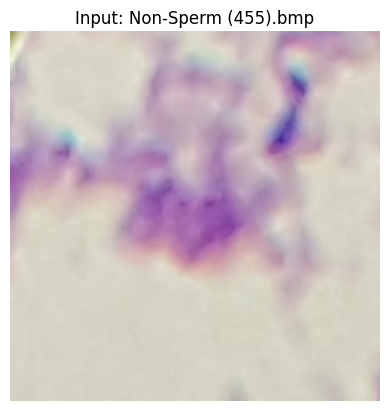

Predicted class: Non-Sperm
  Abnormal_Sperm: 0.100
  Non-Sperm: 0.825
  Normal_Sperm: 0.075

=== Testing: Non-Sperm (594).bmp ===



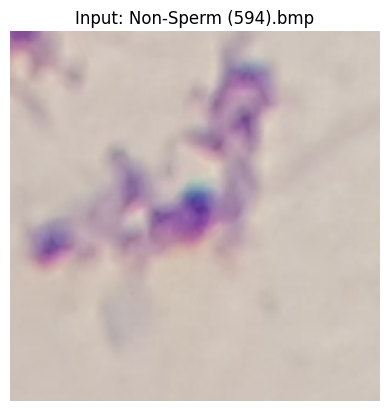

Predicted class: Non-Sperm
  Abnormal_Sperm: 0.111
  Non-Sperm: 0.803
  Normal_Sperm: 0.086

=== Testing: Non-Sperm (155).bmp ===



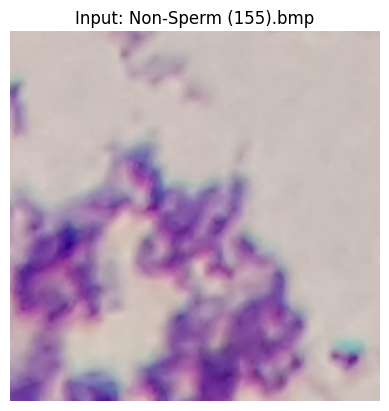

Predicted class: Non-Sperm
  Abnormal_Sperm: 0.013
  Non-Sperm: 0.903
  Normal_Sperm: 0.084

=== Testing: Non-Sperm (413).bmp ===



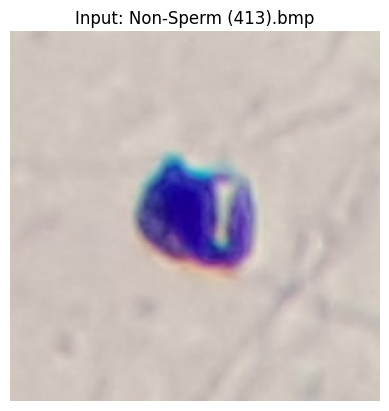

Predicted class: Abnormal_Sperm
  Abnormal_Sperm: 0.362
  Non-Sperm: 0.300
  Normal_Sperm: 0.338

=== Testing: Non-Sperm (782).bmp ===



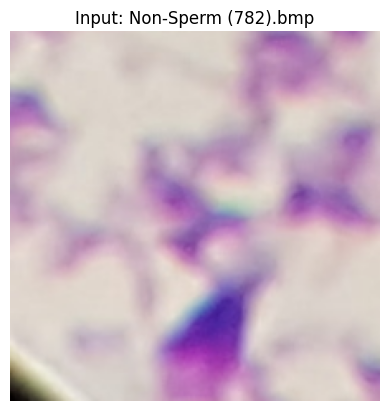

Predicted class: Non-Sperm
  Abnormal_Sperm: 0.088
  Non-Sperm: 0.815
  Normal_Sperm: 0.097


In [26]:
import os

# Directory of all Non-Sperm validation images
val_non_sperm_dir = "/home/oween/Escritorio/Is_it_a_Sperm/data_split/val/Non-Sperm"

#   limit to first 5
bmp_files = [f for f in os.listdir(val_non_sperm_dir) if f.lower().endswith(".bmp")][:5]

# Iterate through them
for fname in bmp_files:
    img_path = os.path.join(val_non_sperm_dir, fname)
    print("\n=== Testing:", fname, "===\n")
    predict_image(img_path, rf_model, class_names)

 
